In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectrum for a single protein complex.
    """
    mz_range = np.arange(1, 20001)
    spectrum = np.zeros_like(mz_range, dtype=float)

    MS = complex_mass
    MA = Q * MS**0.76
    ME = MS + MA
    ZA = 0.0467 * ME**0.533 + F
    TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
    sumT = np.sum(TT)
    WC = np.zeros(maxcharge)
    DE = np.zeros_like(WC)

    for charge in range(maxcharge):
        WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
        if ME > 0:
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA
        else:
            DE[charge] = 0  # Set to 0 if ME is zero or negative

    WD = WC * DE

    for charge in range(1, maxcharge + 1):
        mz = ME / charge
        if mz < len(mz_range):
            lower_limit = max(1, int(mz - resolution / 10))
            upper_limit = min(len(mz_range), int(mz + resolution / 10))
            for axis in range(lower_limit, upper_limit):
                spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                spectrum[axis] += WD[charge - 1] * spread

    noise = np.random.normal(0, noise_level, size=spectrum.size)
    spectrum += noise

    return spectrum

def simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectra for two proteins and their complexes based on an interaction matrix.

    Parameters:
    - monomer_masses: list of float, masses of the two protein monomers in Da
    - interaction_matrix: 2D numpy array, where (0, 0) represents no proteins, (1, 0) represents Protein A monomer, (0, 1) represents Protein B monomer, and so on
    - resolution: float, resolution of the mass spectrometer
    - chargewidth: float, width of the charge distribution
    - maxcharge: int, maximum charge state to consider
    - noise_level: float, standard deviation of Gaussian noise added to the spectrum
    - Q: float, parameter for accounting for adduct binding
    - F: float, parameter for charge state fluctuation
    - AO: float, open area of the detector
    - VA: float, accelerating voltage

    Returns:
    - mz_range: array, m/z range of the spectrum
    - normalized_spectrum: array, combined intensity values across the m/z range for all proteins and complexes, normalized against the sum of intensities
    """
    mz_range = np.arange(1, 20001)
    combined_spectrum = np.zeros_like(mz_range, dtype=float)

    for i, j in np.argwhere(interaction_matrix):
        monomer_mass_A = monomer_masses[0]
        monomer_mass_B = monomer_masses[1]
        stoich_A = i  # Stoichiometry of Protein A
        stoich_B = j  # Stoichiometry of Protein B

        complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B  # Calculate the complex mass according to equation S1
        spectrum = simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
        combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value

    # Normalize the combined spectrum against the sum of intensities
    total_intensity = np.sum(combined_spectrum)
    if total_intensity > 0:
        normalized_spectrum = combined_spectrum / total_intensity
    else:
        normalized_spectrum = combined_spectrum

    return mz_range, normalized_spectrum

In [ ]:
import pandas as pd
import numpy as np 

def create_interaction_matrix(n_proteins):
    """Creates a random interaction matrix for n_proteins
    and then randomises the values in the matrix between 0 and 1
    then takes all non-zero values and replaces them with a random number between 1 and 6"""

    interaction_matrix = np.zeros((n_proteins, n_proteins))
    interaction_matrix = np.random.randint(0, 2, (interaction_matrix.shape))
    interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
    print("your interaction matrix:", interaction_matrix)
    
    return interaction_matrix

def run_all_functions():
    """Runs all functions and returns the mz_range and normalized_spectrum"""
    interaction_matrix = create_interaction_matrix(6)
    monomer_masses = [210000, 18000]
    resolution = 1000
    chargewidth = 5
    maxcharge = 50
    noise_level = 0.000
    Q = 0.1
    F = 1
    AO = 1
    VA = 1

    mz_range, normalized_spectrum = simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
    return mz_range, normalized_spectrum


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(*run_all_functions())

In [ ]:
print(interaction_matrix)

In [ ]:
interaction_matrix[2,3]
interaction_matrix[1,1]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectrum for a single protein complex.
    """
    mz_range = np.arange(1, 20001)
    spectrum = np.zeros_like(mz_range, dtype=float)

    MS = complex_mass
    MA = Q * MS**0.76
    ME = MS + MA
    ZA = 0.0467 * ME**0.533 + F
    TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
    sumT = np.sum(TT)
    WC = np.zeros(maxcharge)
    DE = np.zeros_like(WC)

    for charge in range(maxcharge):
        WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
        DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA if ME > 0 else 0

    WD = WC * DE

    for charge in range(1, maxcharge + 1):
        mz = ME / charge
        if mz < len(mz_range):
            lower_limit = max(1, int(mz - resolution / 10))
            upper_limit = min(len(mz_range), int(mz + resolution / 10))
            for axis in range(lower_limit, upper_limit):
                spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                spectrum[axis] += WD[charge - 1] * spread

    noise = np.random.normal(0, noise_level, size=spectrum.size)
    spectrum += noise

    return spectrum


def simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectra for two proteins and their complexes based on an interaction matrix.

    Parameters:
    - monomer_masses: list of float, masses of the two protein monomers in Da
    - interaction_matrix: 2D numpy array, where (0, 0) represents no proteins, (1, 0) represents Protein A monomer, (0, 1) represents Protein B monomer, and so on
    - resolution: float, resolution of the mass spectrometer
    - chargewidth: float, width of the charge distribution
    - maxcharge: int, maximum charge state to consider
    - noise_level: float, standard deviation of Gaussian noise added to the spectrum
    - Q: float, parameter for accounting for adduct binding
    - F: float, parameter for charge state fluctuation
    - AO: float, open area of the detector
    - VA: float, accelerating voltage

    Returns:
    - mz_range: array, m/z range of the spectrum
    - normalized_spectrum: array, combined intensity values across the m/z range for all proteins and complexes, normalized against the sum of intensities
    """
    mz_range = np.arange(1, 20001)
    combined_spectrum = np.zeros_like(mz_range, dtype=float)

    for i, j in np.argwhere(interaction_matrix > 0):  # Only consider non-zero interactions
        monomer_mass_A = monomer_masses[0]
        monomer_mass_B = monomer_masses[1]
        stoich_A = i  # Stoichiometry of Protein A
        stoich_B = j  # Stoichiometry of Protein B

        complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B  # Calculate the complex mass according to equation S1
        spectrum = simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
        combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value

    # Normalize the combined spectrum against the sum of intensities
    total_intensity = np.sum(combined_spectrum)
    normalized_spectrum = combined_spectrum / total_intensity if total_intensity > 0 else combined_spectrum

    return mz_range, normalized_spectrum


def create_interaction_matrix(n_proteins):
    """
    Creates a random interaction matrix for n_proteins and then randomizes the values in the matrix between 0 and 1.
    Then takes all non-zero values and replaces them with a random number between 1 and 6.
    Returns the interaction matrix as a DataFrame.
    """
    interaction_matrix = np.random.randint(0, 2, (n_proteins, n_proteins))
    interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)

    # Convert the interaction matrix to a DataFrame with meaningful labels
    labels = [f"{i}-mer_{'A' if j == 0 else 'B'}" for i in range(1, n_proteins + 1) for j in range(2)]
    interaction_matrix_df = pd.DataFrame(interaction_matrix, columns=labels[:n_proteins], index=labels[n_proteins:])

    print("Your interaction matrix:")
    print(interaction_matrix_df)

    return interaction_matrix


def run_all_functions():
    """Runs all functions and returns the mz_range and normalized_spectrum"""
    interaction_matrix = create_interaction_matrix(6)
    monomer_masses = [210000, 18000]
    resolution = 1000
    chargewidth = 5
    maxcharge = 50
    noise_level = 0.000
    Q = 0.1
    F = 1
    AO = 1
    VA = 1

    mz_range, normalized_spectrum = simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
    return mz_range, normalized_spectrum


# Run the simulation and plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(*run_all_functions())
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Simulated Mass Spectrum')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz, load_npz
import json

class NativeMassSpecSimulator:
    def __init__(self, monomer_masses, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
        self.monomer_masses = monomer_masses
        self.resolution = resolution
        self.chargewidth = chargewidth
        self.maxcharge = maxcharge
        self.noise_level = noise_level
        self.Q = Q
        self.F = F
        self.AO = AO
        self.VA = VA
        self.run_counter = 0  # Initialize run counter


    def simulate_complex_spectrum(self, complex_mass):

        mz_range = np.arange(1, 20001)
        spectrum = np.zeros_like(mz_range, dtype=float)

        MS = complex_mass
        MA = Q * MS**0.76
        ME = MS + MA
        ZA = 0.0467 * ME**0.533 + F
        TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
        sumT = np.sum(TT)
        WC = np.zeros(maxcharge)
        DE = np.zeros_like(WC)

        for charge in range(maxcharge):
            WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA if ME > 0 else 0

        WD = WC * DE

        for charge in range(1, maxcharge + 1):
            mz = ME / charge
            if mz < len(mz_range):
                lower_limit = max(1, int(mz - resolution / 10))
                upper_limit = min(len(mz_range), int(mz + resolution / 10))
                for axis in range(lower_limit, upper_limit):
                    spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                    spectrum[axis] += WD[charge - 1] * spread

        noise = np.random.normal(0, noise_level, size=spectrum.size)
        spectrum += noise

        return spectrum
    
    def simulate_mass_spectrum(self, interaction_matrix):
        mz_range = np.arange(1, 20001)
        combined_spectrum = np.zeros_like(mz_range, dtype=float)
        peak_labels = []

        for i, j in np.argwhere(interaction_matrix > 0):  # Only consider non-zero interactions
            monomer_mass_A = self.monomer_masses[0]
            monomer_mass_B = self.monomer_masses[1]
            stoich_A = i  # Stoichiometry of Protein A
            stoich_B = j  # Stoichiometry of Protein B

            complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B
            spectrum = self.simulate_complex_spectrum(complex_mass)

            # Generate the peak label based on stoichiometry
            peak_label = f"{stoich_A}A_{stoich_B}B"
            peak_labels.append(peak_label)

            combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value
            total_intensity = np.sum(combined_spectrum)
            normalized_spectrum = combined_spectrum / total_intensity if total_intensity > 0 else combined_spectrum
        # Normalize the combined spectrum against the sum of intensities
            
            return mz_range, normalized_spectrum, peak_labels


    def create_interaction_matrix(self, n_proteins):
        interaction_matrix = np.random.randint(0, 2, (n_proteins, n_proteins))
        interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)

        # Convert the interaction matrix to a DataFrame with meaningful labels
        row_labels = [f"{i}A_{j}B" for i in range(1, n_proteins + 1) for j in range(n_proteins)]
        col_labels = [f"{i}A_{j}B" for i in range(1, n_proteins + 1) for j in range(n_proteins)]
        interaction_matrix_df = pd.DataFrame(interaction_matrix, columns=col_labels[:n_proteins], index=row_labels[:n_proteins])

        #print("Your interaction matrix:")
        #print(interaction_matrix_df)

        return interaction_matrix
    
    def update_interaction_matrix(self, interaction_matrix):
        interaction_matrix = np.where(interaction_matrix >0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
        return interaction_matrix


    def generate_spectra(self, interaction_matrix, num_spectra):
        spectra_data = []
        label_mapping = {}

        for i in range(num_spectra):
            if self.run_counter % 10 == 0: # modulo Update the interaction matrix every 10 runs ### questionable ? should be updated every when runs? 
                interaction_matrix = self.update_interaction_matrix(interaction_matrix)
                
            mz_range, normalized_spectrum, peak_labels = self.simulate_mass_spectrum(interaction_matrix)

            # Bin the m/z values and store the intensity values
            binned_spectrum = []
            for mz, intensity in zip(mz_range, normalized_spectrum):
                bin_idx = int(mz // 100)  # Bin size of 100 m/z units
                binned_spectrum.append((bin_idx, intensity))

            # Update the label mapping
            for label in peak_labels:
                if label not in label_mapping:
                    label_mapping[label] = len(label_mapping)

            self.run_counter += 1  # Increment run counter after each simulation

            spectra_data.append((binned_spectrum, peak_labels))

        return spectra_data, label_mapping

        

In [ ]:

simulator = NativeMassSpecSimulator(
    monomer_masses=[210000, 18000],
    resolution=1000,
    chargewidth=10,
    maxcharge=50,
    noise_level=0.000,
    Q=0.1,
    F=1,
    AO=1,
    VA=1
)

# Generate the interaction matrix - only gen one matrix- is this right? 
n_proteins = 6 # number of protein conformations of protein A and B 
interaction_matrix = simulator.create_interaction_matrix(n_proteins)
print("interaction matrix:", interaction_matrix)

# Generate the spectra data
num_spectra = 100 # number of spectra to generate
spectra_data, label_mapping = simulator.generate_spectra(interaction_matrix, num_spectra)



In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, save_npz
import json

data = []
row_indices = []
col_indices = []
labels = []

# Process each spectrum to collect intensity data and labels
for spectrum_idx, (spectrum, peak_labels) in enumerate(spectra_data):
    # Collect data for the sparse matrix
    for bin_idx, intensity in spectrum:
        data.append(intensity)
        row_indices.append(spectrum_idx)
        col_indices.append(bin_idx)

    # Concatenate the peak labels for the current spectrum
    label_str = ','.join(peak_labels)
    labels.append(label_str)

# Determine the number of bins (the max index + 1 ensures all indices are covered)
num_bins = max(col_indices) + 1 if col_indices else 0

# Create the CSR matrix from the collected data
sparse_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(len(spectra_data), num_bins))

# Save the sparse matrix to an NPZ file
save_npz("sparse_matrix.npz", sparse_matrix)

# Save the labels as a numpy array to maintain the structure
np.save("labels.npy", np.array(labels))

# Save the label mapping to a JSON file for easy lookup and reference
with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f)


In [ ]:
import numpy as np
from scipy.sparse import load_npz

# Load the sparse matrix from the NPZ file
sparse_matrix = load_npz("sparse_matrix.npz")

# Print the shape of the matrix to understand its dimensions
print("Shape of sparse matrix:", sparse_matrix.shape)

# Convert the sparse matrix to a dense format and print a small portion to see its content
print("Contents of sparse matrix (small portion):")
print(sparse_matrix.toarray()[:5])  # Adjust the slice as necessary to limit output


In [ ]:
# Load the labels from the numpy file
labels = np.load("labels.npy")

# Print the first few labels to see how they are structured
print("First few labels:")
print(labels[:100])  # Adjust the number to display more or fewer labels


In [ ]:
# Optional: Examine a specific row of the sparse matrix and its corresponding label
row_index = 6  # Example row index
print("Specific spectrum (row) from sparse matrix:")
print(sparse_matrix.getrow(row_index).toarray())

print("Label for this spectrum:")
print(labels[row_index])


In [ ]:
import numpy as np
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

# Load the sparse matrix and labels
sparse_matrix = load_npz("sparse_matrix.npz")
labels = np.load("labels.npy")

# Function to plot a specified number of spectra
def plot_spectra(sparse_matrix, labels, num_spectra=5):
    plt.figure(figsize=(10, 7))
    
    # Ensure we do not try to plot more spectra than we have
    num_spectra = min(num_spectra, sparse_matrix.shape[0])
    
    for i in range(num_spectra):
        # Get the i-th row of the sparse matrix and convert it to a dense format
        spectrum = sparse_matrix.getrow(i).toarray().ravel()
        
        # Plot the spectrum
        plt.plot(spectrum, label=f'Spectrum {i+1} - {labels[i]}')
    
    plt.title('Sample Spectra from Sparse Matrix')
    plt.xlabel('m/z Bins')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot spectra
plot_spectra(sparse_matrix, labels, num_spectra=3)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz, load_npz
import json

class NativeMassSpecSimulator:
    def __init__(self, monomer_masses, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
        self.monomer_masses = monomer_masses
        self.resolution = resolution
        self.chargewidth = chargewidth
        self.maxcharge = maxcharge
        self.noise_level = noise_level
        self.Q = Q
        self.F = F
        self.AO = AO
        self.VA = VA
        #self.run_counter = 0  # Initialize run counter

    def simulate_complex_spectrum(self, complex_mass):
        mz_range = np.arange(1, 20001)
        spectrum = np.zeros_like(mz_range, dtype=float)

        MS = complex_mass
        MA = self.Q * MS**0.76
        ME = MS + MA
        ZA = 0.0467 * ME**0.533 + self.F
        TT = np.exp(-(np.arange(self.maxcharge) - 50)**2 / self.chargewidth)
        sumT = np.sum(TT)
        WC = np.zeros(self.maxcharge)
        DE = np.zeros_like(WC)

        for charge in range(self.maxcharge):
            WC[charge] = np.exp(-(charge + 1 - ZA)**2 / self.chargewidth) / sumT
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * self.AO * self.VA if ME > 0 else 0

        WD = WC * DE

        for charge in range(1, self.maxcharge + 1):
            mz = ME / charge
            if mz < len(mz_range):
                lower_limit = max(1, int(mz - self.resolution / 10))
                upper_limit = min(len(mz_range), int(mz + self.resolution / 10))
                for axis in range(lower_limit, upper_limit):
                    spread = np.exp(-((axis - mz)**2) / (2 * (self.resolution / 100)**2))
                    spectrum[axis] += WD[charge - 1] * spread

        noise = np.random.normal(0, self.noise_level, size=spectrum.size)
        spectrum += noise

        return spectrum
    
    def simulate_mass_spectrum(self, interaction_matrix):
        mz_range = np.arange(1, 20001)
        combined_spectrum = np.zeros_like(mz_range, dtype=float)
       # peak_labels = []

        for i, j in np.argwhere(interaction_matrix > 0):

            stoich_A = i   # Stoichiometry of Protein A, adjusted for biological indexing
            stoich_B = j   # Stoichiometry of Protein B, adjusted for biological indexing

            complex_mass = stoich_A * self.monomer_masses[0] + stoich_B * self.monomer_masses[1]
            spectrum = self.simulate_complex_spectrum(complex_mass)

            # Scale the spectrum by the interaction matrix value
            scaled_spectrum = spectrum * interaction_matrix[i, j]

            # Generate the peak label based on stoichiometry
            # peak_label = f"{stoich_A +1}A_{stoich_B +1}B_{interaction_matrix[i, j]}"
            # peak_labels.append(peak_label)

            combined_spectrum += scaled_spectrum
            
        # Normalize the combined spectrum after summing contributions from all interactions
        total_intensity = np.sum(combined_spectrum)
        normalized_spectrum = combined_spectrum / total_intensity if total_intensity > 0 else combined_spectrum

        print("normalized_spectrum:", normalized_spectrum)
        # print("peak_labels:", peak_labels)
        
        return mz_range, normalized_spectrum


    def create_interaction_matrix(self, n_proteins):
        interaction_matrix = np.random.randint(0, 2, (n_proteins, n_proteins))
        interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
        return interaction_matrix
    
    def update_interaction_matrix(self, interaction_matrix):
        # Randomly update non-zero values in the interaction matrix
        interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
        print("updated interaction matrix:", interaction_matrix)

        return interaction_matrix

    def generate_spectra(self, n_proteins, num_spectra):
        spectra_data = []
        #label_mapping = {}

        interaction_matrix = self.create_interaction_matrix(n_proteins)

        for i in range(num_spectra):
            # if self.run_counter % 5 == 0:
            interaction_matrix = self.update_interaction_matrix(interaction_matrix)
                #label_mapping = {}  # Reset the label mapping after updating the interaction matrix

            mz_range, normalized_spectrum = self.simulate_mass_spectrum(interaction_matrix)

            # Bin the m/z values and store the intensity values
            binned_spectrum = []
            for mz, intensity in zip(mz_range, normalized_spectrum):
                bin_idx = int(mz // 100)  # Bin size of 100 m/z units
                binned_spectrum.append((bin_idx, intensity))

            # # Update the label mapping
            # for label in peak_labels:
            #     if label not in label_mapping:
            #         label_mapping[label] = len(label_mapping)

            # print("counter:", self.run_counter)
            # self.run_counter += 1  # Increment run counter after each simulation

            spectra_data.append((binned_spectrum))

        return spectra_data


In [ ]:

simulator = NativeMassSpecSimulator(
    monomer_masses=[210000, 18000],
    resolution=1000,
    chargewidth=10,
    maxcharge=50,
    noise_level=0.000,
    Q=0.1,
    F=1,
    AO=1,
    VA=1
)

# Generate the interaction matrix - only gen one matrix- is this right? 
n_proteins = 6  # Set the desired number of protein conformations of protein A and B (square)
num_spectra = 100  # Set the desired number of spectra to generate
spectra_data = simulator.generate_spectra(n_proteins, num_spectra)



In [ ]:
print(np.shape(spectra_data))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've loaded your data from an NPZ file or have it from previous steps
data = np.load('spectra.npz')
all_spectra = data['spectra'[:,1:]]
interaction_matrices = data['interaction_matrices']

# 1. Verify the shape
print("Shape of all_spectra:", all_spectra.shape)
print("Shape of interaction_matrices:", interaction_matrices.shape)

# 2. Plot a few spectra
def plot_spectra(spectra, num_plots=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_plots):
        plt.plot(spectra[i], label=f'Spectrum {i+1}')
    plt.title('Sample Spectra')
    plt.xlabel('Bin Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

plot_spectra(all_spectra)

# 3. View interaction matrices
def view_interaction_matrices(matrices, num_matrices=3):
    fig, axes = plt.subplots(1, num_matrices, figsize=(15, 5))
    for i in range(num_matrices):
        ax = axes[i] if num_matrices > 1 else axes
        cax = ax.matshow(matrices[i], cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Interaction Matrix {i+1}')
    plt.show()

view_interaction_matrices(interaction_matrices)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the spectra and interaction matrices from the NPZ file
loaded_data = np.load('spectra.npz')
spectra = loaded_data['spectra']
interaction_matrices = loaded_data['interaction_matrices']

# Create a figure and subplots
fig, axs = plt.subplots(2, spectra.shape[0], figsize=(15, 8))

# Plot each spectrum and its interaction matrix
for i in range(spectra.shape[0]):
    # Plot the spectrum
    mz_range = spectra[i, 0, :]
    intensity = spectra[i, 1, :]
    axs[0, i].plot(mz_range, intensity)
    axs[0, i].set_xlabel('m/z')
    axs[0, i].set_ylabel('Intensity')
    axs[0, i].set_title(f'Spectrum {i+1}')

    # Plot the interaction matrix as a heatmap
    im = axs[1, i].imshow(interaction_matrices[i], cmap='viridis', aspect='equal')
    axs[1, i].set_xlabel('Protein')
    axs[1, i].set_ylabel('Protein')
    axs[1, i].set_title(f'Interaction Matrix {i+1}')
    axs[1, i].set_xticks(range(interaction_matrices[i].shape[1]))
    axs[1, i].set_yticks(range(interaction_matrices[i].shape[0]))

    # Add colorbar for the interaction matrix heatmap
    cbar = fig.colorbar(im, ax=axs[1, i], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Interaction Strength')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've loaded your data from an NPZ file or have it from previous steps
data = np.load('spectra.npz')
all_spectra = data['spectra'][:, 1:]
interaction_matrices = data['interaction_matrices']

# 1. Verify the shape
print("Shape of all_spectra:", all_spectra.shape)
print("Shape of interaction_matrices:", interaction_matrices.shape)

# 2. Plot a few spectra
def plot_spectra(spectra, num_plots=1):
    plt.figure(figsize=(15, 5))
    for i in range(num_plots):
        plt.plot(spectra[i], label=f'Spectrum {i+1}')
    plt.title('Sample Spectra')
    plt.xlabel('Bin Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

plot_spectra(all_spectra)

# 3. View interaction matrices
def view_interaction_matrices(matrices, num_matrices=3):
    fig, axes = plt.subplots(1, num_matrices, figsize=(10, 5))
    for i in range(num_matrices):
        ax = axes[i] if num_matrices > 1 else axes
        cax = ax.matshow(matrices[i], cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Interaction Matrix {i+1}')
    plt.show()

view_interaction_matrices(interaction_matrices)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've loaded your data from an NPZ file
data = np.load('spectra.npz')
spectra = data['spectra']

# Select a single spectrum (e.g., the first spectrum)
spectrum_index = 20
spectrum = spectra[spectrum_index]

# Extract the m/z range and intensity values
mz_range = spectrum[0]
intensity = spectrum[1]

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(mz_range, intensity)
plt.title(f'Spectrum {spectrum_index+1}')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've loaded your data from an NPZ file
data = np.load('spectra.npz')
spectra = data['spectra']

# Select a single spectrum (e.g., the first spectrum)
spectrum_index =700

spectrum = spectra[spectrum_index]

# Extract the m/z range and intensity values
mz_range = spectrum[0]
intensity = spectrum[1]

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(mz_range, intensity)
plt.title(f'Spectrum {spectrum_index+1}')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import entropy

entropies = []
for matrix in interaction_matrices:
    flat_matrix = matrix.flatten()

    value_counts = np.bincount(flat_matrix)
    probabilities = value_counts / np.sum(value_counts)

    entropy_value = entropy(probabilities)
    entropies.append(entropy_value)

for i, entropy_value in enumerate(entropies):
    print(f"Entropy of Interaction Matrix {i+1}: {entropy_value:.4f}")

average_entropy = np.mean(entropies)
print(f"Average Entropy of Interaction Matrices: {average_entropy:.4f}")

In [ ]:
import math

max_entropies = []
for matrix in interaction_matrices:
    # Count the number of unique values in the matrix
    unique_values = np.unique(matrix)
    num_unique_values = len(unique_values)
    
    # Calculate the maximum entropy
    max_entropy = math.log2(num_unique_values)
    max_entropies.append(max_entropy)

# Print the maximum entropies
for i, max_entropy in enumerate(max_entropies):
    print(f"Maximum Entropy of Interaction Matrix {i+1}: {max_entropy:.4f}")

# Calculate the average maximum entropy across all matrices
average_max_entropy = np.mean(max_entropies)
print(f"\nAverage Maximum Entropy: {average_max_entropy:.4f}")

In [ ]:
import h5py

# Open the HDF5 file
file = h5py.File('spectra.h5', 'r')

# Print the length of the file
print(len(file))

# Close the file
file.close()


In [ ]:
import torch 

torch.load('spectra_dataset.pt')
spectra_dataset = torch.load('spectra_dataset.pt')

In [ ]:
spectra_dataset.shape

In [ ]:
import matplotlib.pyplot as plt

# Plot the first spectrum
plt.figure(figsize=(12, 6))
plt.plot(spectra_dataset[0])
plt.title('First Spectrum')
plt.xlabel('mz')


In [399]:
import pickle

with open ('spectra_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

torch.Size([10, 20000])


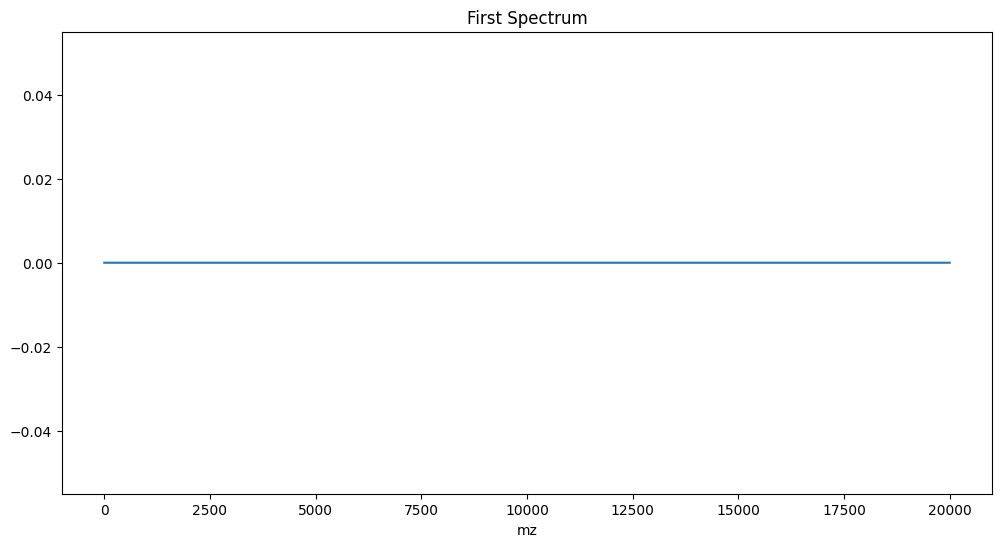

In [400]:
import matplotlib.pyplot as plt

# Plot the first spectrum
plt.figure(figsize=(12, 6))
plt.plot(data[0])
plt.title('First Spectrum')
plt.xlabel('mz')

print(data.shape)


In [396]:
with open('interaction_matrices.pkl', 'rb') as f:
    interaction_matrices = pickle.load(f)

print(interaction_matrices.shape)


torch.Size([10, 6, 6])


Text(0.5, 1.0, 'First Interaction Matrix')

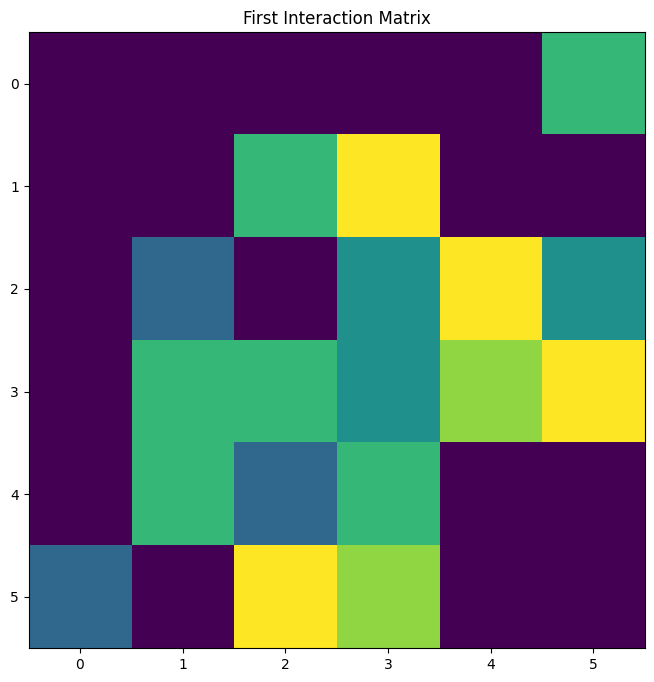

In [397]:
import matplotlib.pyplot as plt

# Plot the first interaction matrix
plt.figure(figsize=(8, 8))
plt.imshow(interaction_matrices[0], cmap='viridis')
plt.title('First Interaction Matrix')
